# Import libraries

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch as th
import torch.nn.functional as F
import torch.nn as nn 
from torch import optim
#from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split,  RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_poisson_deviance, d2_tweedie_score, make_scorer, auc
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import stats
import os
from skorch import NeuralNetRegressor, NeuralNet, callbacks
from skorch.helper import predefined_split
import skorch
from skorch.dataset import Dataset, ValidSplit
import utils

# Load Models

In [2]:
# Define architecture
class MultipleRegression(nn.Module):
    def __init__(self, num_features=39, num_units_1=20, num_units_2=60, activation=nn.Tanh, dropout_rate=0):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, num_units_1)
        self.layer_2 = nn.Linear(num_units_1, num_units_2)
        self.layer_out = nn.Linear(num_units_2, 1)
        self.dropout = nn.Dropout(dropout_rate)
        
        #self.relu = nn.ReLU()
        self.act = activation()

        th.nn.init.xavier_uniform_(self.layer_1.weight)
        th.nn.init.zeros_(self.layer_1.bias)
        th.nn.init.xavier_uniform_(self.layer_2.weight)
        th.nn.init.zeros_(self.layer_2.bias)
        th.nn.init.xavier_uniform_(self.layer_out.weight)
        th.nn.init.zeros_(self.layer_out.bias)
    
    def forward(self, inputs):
        x = self.dropout(self.act(self.layer_1(inputs)))
        x = self.dropout(self.act(self.layer_2(x)))
        x = th.exp(self.layer_out(x))

        return (x)

    def predict(self, test_inputs):
        x = self.act(self.layer_1(test_inputs))
        x = self.act(self.layer_2(x))
        x = th.exp(self.layer_out(x))

        return (x)

In [3]:
loaded_net_regr = NeuralNetRegressor(
    MultipleRegression().double(),
    optimizer=optim.NAdam,
    criterion=nn.PoissonNLLLoss(log_input= False, full= True),
    max_epochs=50,
    batch_size=10_000,
    #train_split=skorch.dataset.ValidSplit(0.1, stratified=False, random_state=rng), # use 10% to set early stopping
    #callbacks=[pde_callback, early_stopping_callback, check_point_callback],
    device=None, # ignore CUDA for now
    iterator_train__shuffle=True
)
loaded_net_regr.initialize()  # This is important!
loaded_net_regr.load_params(f_params=f'../ag_-1/agent_-1_model.pkl', 
                                       f_optimizer=f'../ag_-1/agent_-1_opt.pkl', 
                                       f_history=f'../ag_-1/agent_-1_history.json')

c:\Users\dylan\anaconda3\envs\flower\lib\site-packages\skorch\net.py:2433: DeviceWarning: Setting self.device = cpu since the requested device was not specified
  warnings.warn(msg, DeviceWarning)


In [4]:
# Define architecture
class MultipleRegression(nn.Module):
    def __init__(self, num_features=39, num_units_1=40, num_units_2=60, activation=nn.Tanh, dropout_rate=0):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, num_units_1)
        self.layer_2 = nn.Linear(num_units_1, num_units_2)
        self.layer_out = nn.Linear(num_units_2, 1)
        self.dropout = nn.Dropout(dropout_rate)
        
        #self.relu = nn.ReLU()
        self.act = activation()

        th.nn.init.xavier_uniform_(self.layer_1.weight)
        th.nn.init.zeros_(self.layer_1.bias)
        th.nn.init.xavier_uniform_(self.layer_2.weight)
        th.nn.init.zeros_(self.layer_2.bias)
        th.nn.init.xavier_uniform_(self.layer_out.weight)
        th.nn.init.zeros_(self.layer_out.bias)
    
    def forward(self, inputs):
        x = self.dropout(self.act(self.layer_1(inputs)))
        x = self.dropout(self.act(self.layer_2(x)))
        x = th.exp(self.layer_out(x))

        return (x)

    def predict(self, test_inputs):
        x = self.act(self.layer_1(test_inputs))
        x = self.act(self.layer_2(x))
        x = th.exp(self.layer_out(x))

        return (x)

In [5]:
loaded_net_regr_0 = NeuralNetRegressor(
    MultipleRegression().double(),
    optimizer=optim.NAdam,
    criterion=nn.PoissonNLLLoss(log_input= False, full= True),
    max_epochs=50,
    batch_size=10_000,
    #train_split=skorch.dataset.ValidSplit(0.1, stratified=False, random_state=rng), # use 10% to set early stopping
    #callbacks=[pde_callback, early_stopping_callback, check_point_callback],
    device=None, # ignore CUDA for now
    iterator_train__shuffle=True
)
loaded_net_regr_0.initialize()  # This is important!
loaded_net_regr_0.load_params(f_params=f'../ag_0/agent_0_model.pkl', 
                                       f_optimizer=f'../ag_0/agent_0_opt.pkl', 
                                       f_history=f'../ag_0/agent_0_history.json')

# Load Test Data and Functions

In [6]:
def frequency_conversion(FACTOR, df, freq_dictionary):
      for key in freq_dictionary:
            df[freq_dictionary[key]]=df[key]/df['Exposure']

      df.insert(1,FACTOR+'_binned_midpoint',[round((a.left + a.right)/2,0) for a in df[FACTOR+'_binned']])

In [7]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [8]:
def create_test_data(): 
    (X_train, X_val, X_test, y_train, y_val, y_test, X_column_names, scaler) = utils.upload_dataset()
    
    MY_DATA_PATH = '../data'
    
    X_test_sc = pd.read_csv(MY_DATA_PATH + '/X_test.csv')
    y_te = pd.read_csv(MY_DATA_PATH + '/y_test.csv')
    X_column_names = X_test_sc.columns.tolist()

    test_complete_data=np.column_stack((X_test_sc, y_te))

    X_column_names.append('ClaimNb')

    #Convert dataset of test data, actuals, and prediction back into dataframe

    df_test=pd.DataFrame(data=test_complete_data,    # values
                    columns=X_column_names)  # 1st row as the column names
    
    # Un one-hot encode Region and VehBrand
    df_test = undummify(df_test)
    df_test['VehBrand_number'] = df_test['VehBrand'].str[1:].astype(int)
    df_test['Region_number'] = df_test['Region'].str[1:].astype(int)


    df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']]=scaler.inverse_transform(df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']] )
    
    #Bin factors
    factor_list = ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehGas', 'Density', 'VehBrand_number', 'Region_number']
    
    # If fewer levels than MAX_BINSIZE no effective binning happens via the min() function, not used currently
    MAX_BINSIZE = 20

    # Automatic binning not used, could use qcut as well 
    for i in factor_list:
        df_test[i+'_binned'] = pd.cut(df_test[i], bins=min(len(df_test[i].unique()), MAX_BINSIZE), duplicates='drop')
        #df_test[i+'_binned'] = pd.cut(df_test[i], bins=np.linspace(0, max(df_test[i]), min(21, len(df_test[i].unique()))), duplicates='drop')
    
    # Custom binning used instead to define more sensible bins
    df_test['Area'+'_binned'] = pd.cut(df_test['Area'], bins=np.linspace(0, 7, 8), duplicates='drop')
    df_test['VehPower'+'_binned'] = pd.cut(df_test['VehPower'], bins=np.linspace(0, 15, 16), duplicates='drop')
    df_test['VehAge'+'_binned'] = pd.cut(df_test['VehAge'], bins=np.linspace(0, 20, 21), duplicates='drop')
    df_test['DrivAge'+'_binned'] = pd.cut(df_test['DrivAge'], bins=np.linspace(0, 100, 21), duplicates='drop')
    df_test['BonusMalus'+'_binned'] = pd.qcut(df_test['BonusMalus'], q=15, duplicates='drop') # note usin qcut here
    df_test['Density'+'_binned'] = pd.cut(df_test['Density'], bins=np.linspace(0, 11, 12), duplicates='drop')
    df_test['VehBrand_number'+'_binned'] = pd.cut(df_test['VehBrand_number'], bins=np.linspace(0, 15, 16), duplicates='drop')
    df_test['Region_number'+'_binned'] = pd.cut(df_test['Region_number'], bins=np.linspace(0, 100, 21), duplicates='drop')
    df_test['VehGas'+'_binned'] = pd.cut(df_test['VehGas'], bins=np.linspace(0, 2, 3), duplicates='drop')
    
    return X_test, y_test, df_test

In [9]:
X_test, y_test, df_test = create_test_data()

In [10]:
def create_df_sum(df_test, factor, X_test, global_model, agent_model):
    
    y_pred = global_model.predict(X_test.astype(np.float64))
    df_test['ClaimNb_pred']=pd.Series(y_pred.flatten())

    y_agent_pred = agent_model.predict(X_test.astype(np.float64))
    df_test['ClaimNb_agent_pred']=pd.Series(y_agent_pred.flatten())

    df_sum=df_test.groupby([factor+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_agent_pred'].sum().reset_index()

    frequency_conversion(factor, df_sum, {'ClaimNb':'Actual freq', 'ClaimNb_pred':'Freq pred global model', 'ClaimNb_agent_pred':'Freq pred local model',})

    # Remove rows with 0 exposure
    df_sum = df_sum.loc[df_sum['Exposure']!=0]
    df_sum = df_sum.reset_index(drop=True)

    return df_sum

In [11]:
def one_way_graph_comparison(factor):

        df_sum = create_df_sum(df_test, factor, X_test, loaded_net_regr, loaded_net_regr_0)

        fig, ax = plt.subplots(figsize=(12, 8))

        plt.plot(df_sum['Actual freq'],  
                label='Actual freq',
                marker='o',
                )

        plt.plot(df_sum['Freq pred local model'],  
                label='Freq pred local model',
                marker='o',
                linestyle='dashed',
                )

        plt.plot(df_sum['Freq pred global model'],  
                label='Freq pred global model',
                marker='o',
                linestyle='dotted',
                )

        plt.legend(bbox_to_anchor=(1.08, 1), loc='upper left', borderaxespad=0)

        plt.xlabel(factor+'_binned')
        plt.xticks(rotation = 75)
        plt.ylabel('Frequency')
        plt.grid()


        # Get second axis
        ax2 = ax.twinx()

        plt.bar(df_sum[factor+'_binned'].astype(str), 
                df_sum['Exposure'], 
                label='Exposure', 
                color='y',
                alpha=0.35
                )

        plt.ylabel('Exposure', color='y')
        plt.xticks(rotation = 90)

        vals = ax2.get_yticks()
        ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

        plt.legend(bbox_to_anchor=(1.08, 0.89), loc='upper left', borderaxespad=0)

        plt.show()

# Graphs

C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\311038698.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sum=df_test.groupby([factor+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_agent_pred'].sum().reset_index()
C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\376033308.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


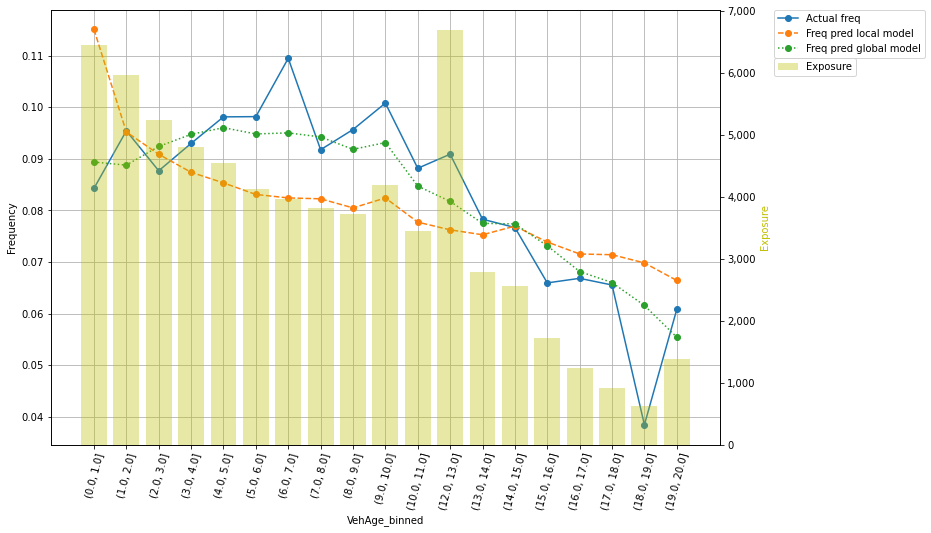

In [12]:
one_way_graph_comparison('VehAge')

C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\311038698.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sum=df_test.groupby([factor+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_agent_pred'].sum().reset_index()
C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\376033308.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


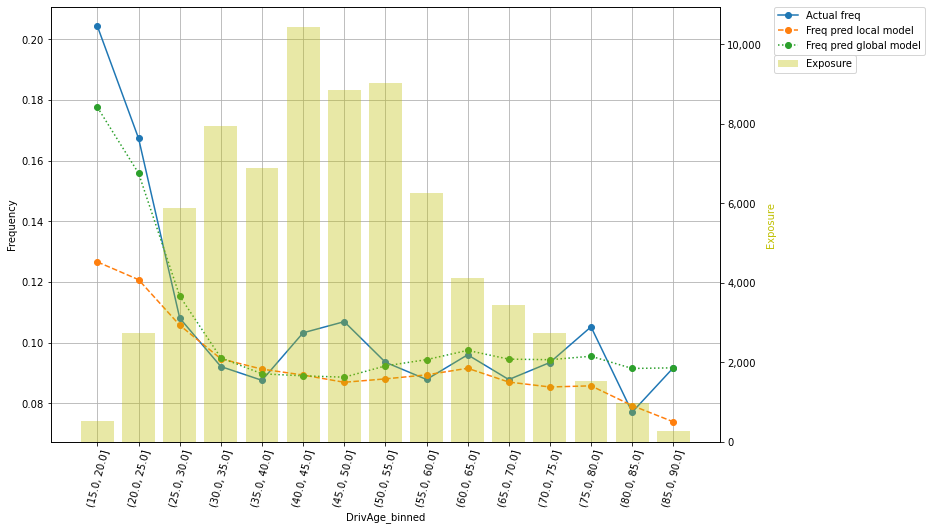

In [13]:
one_way_graph_comparison('DrivAge')

C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\311038698.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sum=df_test.groupby([factor+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_agent_pred'].sum().reset_index()
C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\376033308.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


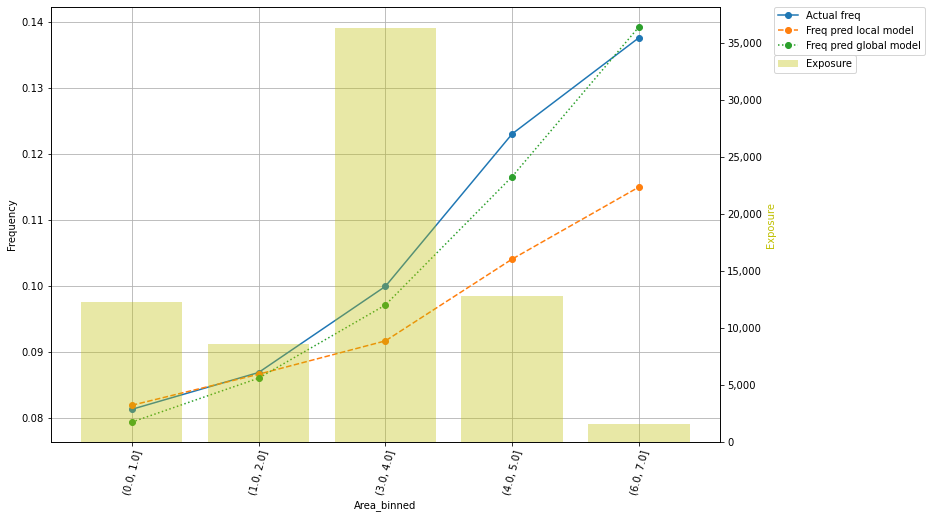

C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\311038698.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sum=df_test.groupby([factor+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_agent_pred'].sum().reset_index()
C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\376033308.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


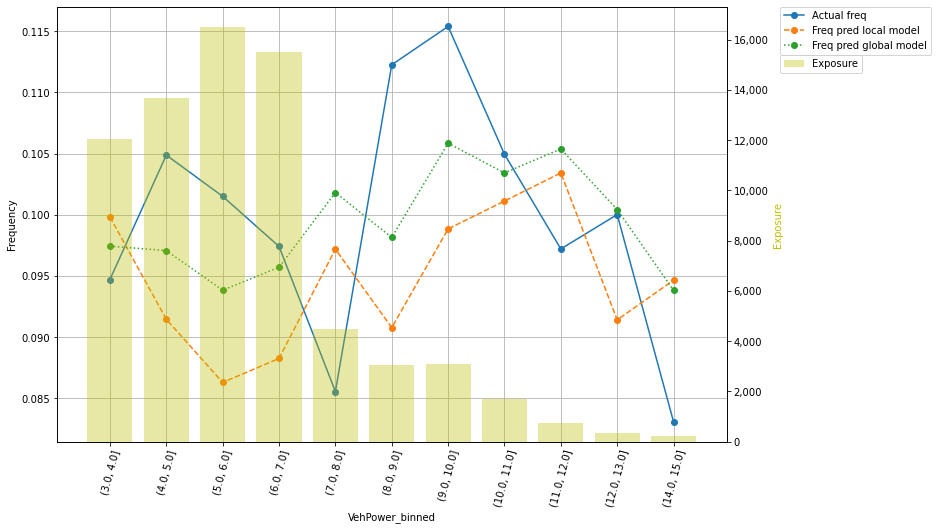

C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\311038698.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sum=df_test.groupby([factor+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_agent_pred'].sum().reset_index()
C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\376033308.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


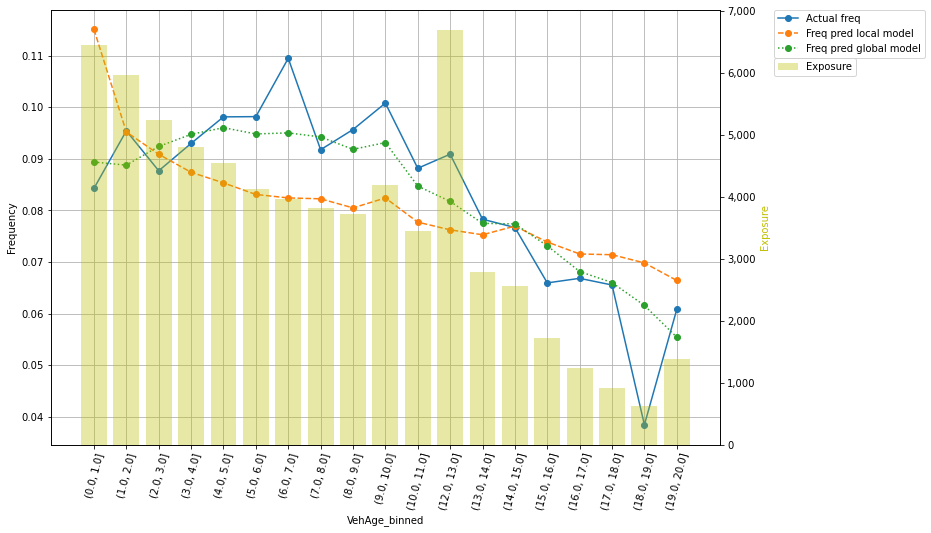

C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\311038698.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sum=df_test.groupby([factor+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_agent_pred'].sum().reset_index()
C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\376033308.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


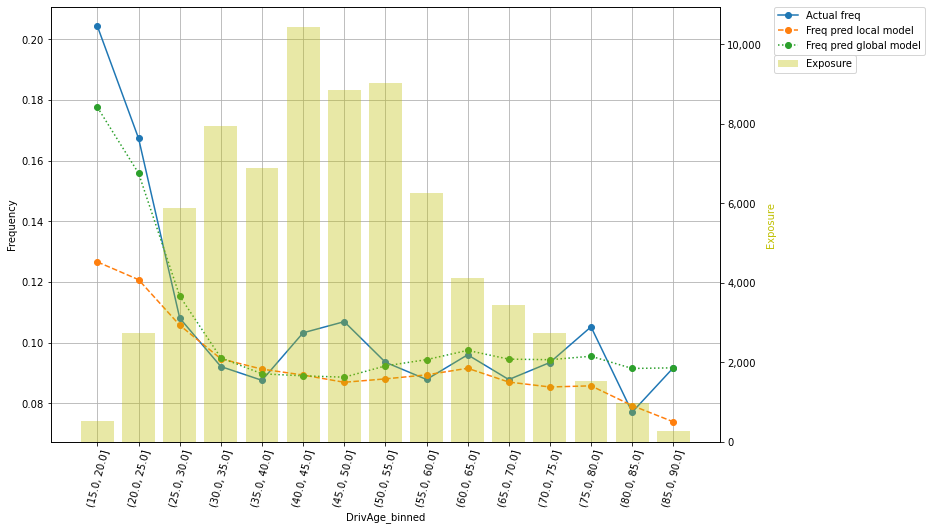

C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\311038698.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sum=df_test.groupby([factor+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_agent_pred'].sum().reset_index()
C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\376033308.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


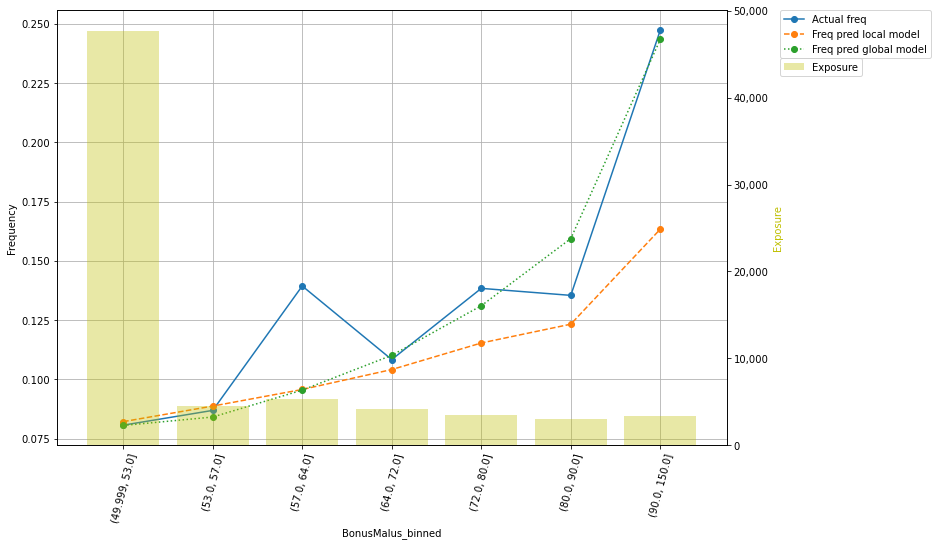

C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\311038698.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sum=df_test.groupby([factor+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_agent_pred'].sum().reset_index()
C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\376033308.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


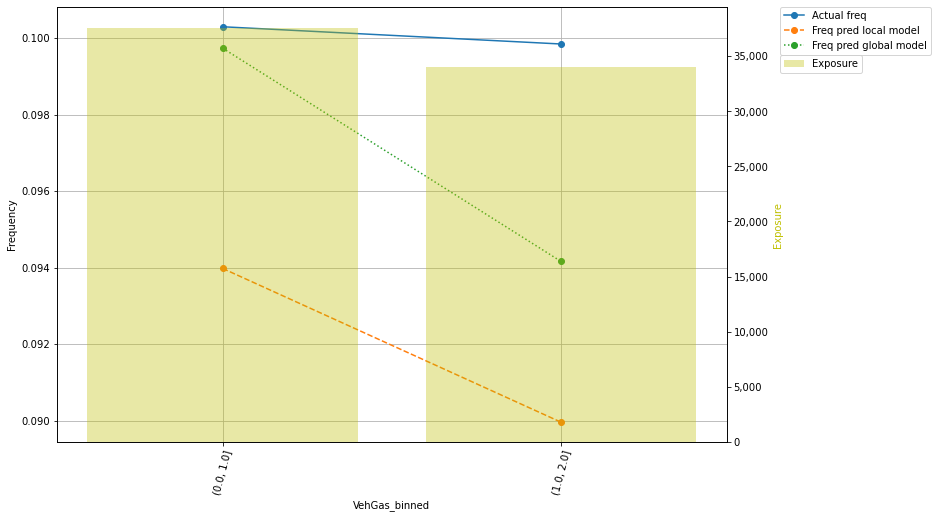

C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\311038698.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sum=df_test.groupby([factor+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_agent_pred'].sum().reset_index()
C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\376033308.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


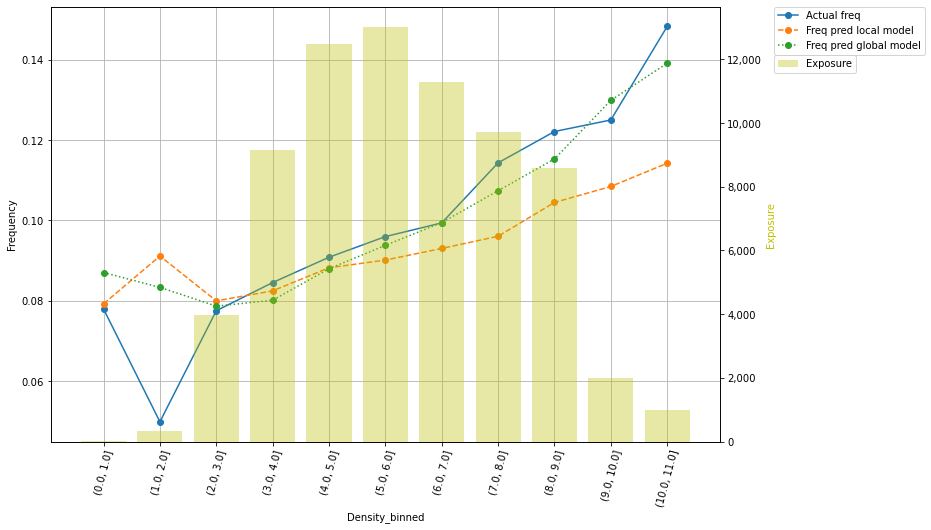

C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\311038698.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sum=df_test.groupby([factor+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_agent_pred'].sum().reset_index()
C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\376033308.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


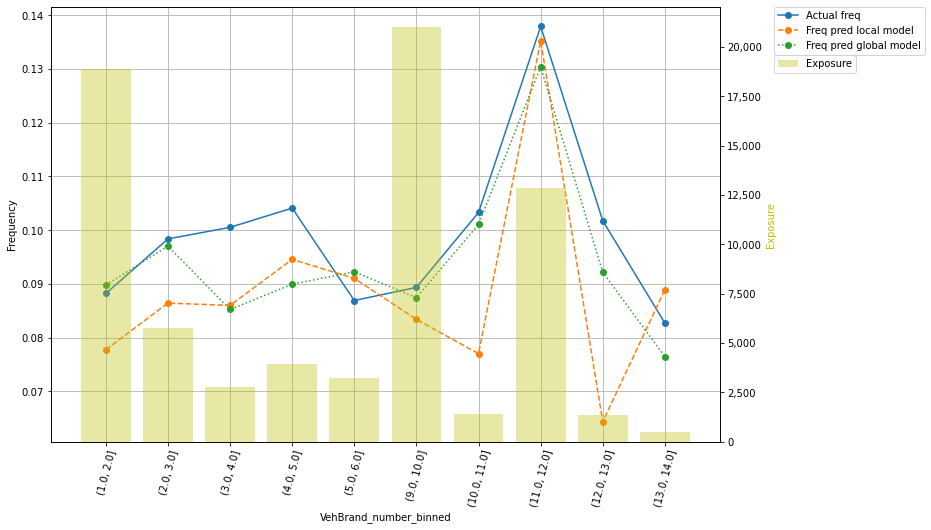

C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\311038698.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sum=df_test.groupby([factor+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_agent_pred'].sum().reset_index()
C:\Users\dylan\AppData\Local\Temp\ipykernel_43556\376033308.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


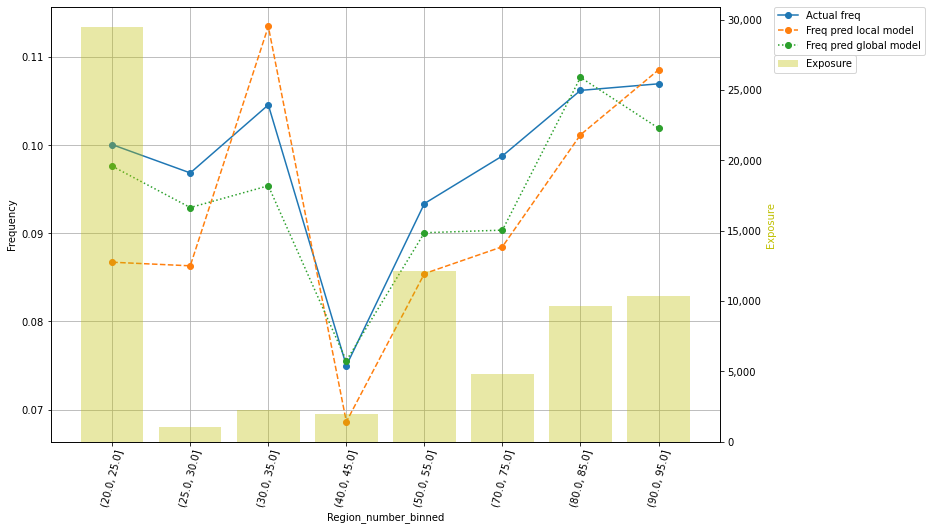

In [14]:
for i in ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehGas', 'Density', 'VehBrand_number', 'Region_number']:
    one_way_graph_comparison(i)

# End

In [34]:
len(df_test['DrivAge'].unique())

73

In [20]:
df_test

,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehGas,Density,VehBrand_B10,VehBrand_B11,...,ClaimNb,Area_binned,VehPower_binned,VehAge_binned,DrivAge_binned,BonusMalus_binned,VehGas_binned,Density_binned,ClaimNb_pred,ClaimNb_agent_pred
0,1.000000,1.0,4.0,11.0,45.0,50.0,1.0,2.197225,0.0,0.0,...,0.0,"(0.995, 1.333]","(3.989, 4.733]","(10.667, 12.0]","(42.0, 46.8]","(49.9, 56.667]","(0.999, 1.067]","(2.041, 2.721]",0.036276,0.047628
1,0.700000,3.0,7.0,3.0,26.0,68.0,1.0,5.774552,0.0,0.0,...,0.0,"(3.0, 3.333]","(6.933, 7.667]","(2.667, 4.0]","(22.8, 27.6]","(63.333, 70.0]","(0.999, 1.067]","(5.442, 6.122]",0.069852,0.055344
2,0.460000,4.0,9.0,15.0,21.0,95.0,1.0,6.960348,0.0,0.0,...,0.0,"(3.667, 4.0]","(8.4, 9.133]","(14.667, 16.0]","(17.928, 22.8]","(90.0, 96.667]","(0.999, 1.067]","(6.802, 7.483]",0.065300,0.040753
3,0.450000,5.0,4.0,0.0,69.0,50.0,1.0,8.325548,0.0,0.0,...,0.0,"(4.667, 5.0]","(3.989, 4.733]","(-0.02, 1.333]","(66.0, 70.8]","(49.9, 56.667]","(0.999, 1.067]","(8.163, 8.843]",0.164434,0.134923
4,0.490000,6.0,9.0,1.0,57.0,50.0,1.0,10.060320,0.0,0.0,...,1.0,"(5.667, 6.0]","(8.4, 9.133]","(-0.02, 1.333]","(56.4, 61.2]","(49.9, 56.667]","(0.999, 1.067]","(9.523, 10.204]",0.057134,0.042652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135598,0.070000,3.0,9.0,0.0,53.0,50.0,1.0,5.953243,0.0,0.0,...,1.0,"(3.0, 3.333]","(8.4, 9.133]","(-0.02, 1.333]","(51.6, 56.4]","(49.9, 56.667]","(0.999, 1.067]","(5.442, 6.122]",0.140251,0.085198
135599,0.110000,3.0,9.0,16.0,37.0,50.0,1.0,6.003887,0.0,0.0,...,0.0,"(3.0, 3.333]","(8.4, 9.133]","(14.667, 16.0]","(32.4, 37.2]","(49.9, 56.667]","(0.999, 1.067]","(5.442, 6.122]",0.011687,0.031358
135600,0.008219,4.0,7.0,0.0,56.0,50.0,1.0,6.628041,0.0,0.0,...,0.0,"(3.667, 4.0]","(6.933, 7.667]","(-0.02, 1.333]","(51.6, 56.4]","(49.9, 56.667]","(0.999, 1.067]","(6.122, 6.802]",0.119768,0.049258
135601,0.280000,5.0,5.0,17.0,50.0,90.0,1.0,9.138522,0.0,0.0,...,0.0,"(4.667, 5.0]","(4.733, 5.467]","(16.0, 17.333]","(46.8, 51.6]","(83.333, 90.0]","(0.999, 1.067]","(8.843, 9.523]",0.059391,0.050850


In [27]:
df_sum = create_df_sum(df_test, 'Region_number', X_test, loaded_net_regr, loaded_net_regr_0)
df_sum = df_sum.reset_index(drop=True)
df_sum

C:\Users\dylan\AppData\Local\Temp\ipykernel_41948\3342799862.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sum=df_test.groupby([factor+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_agent_pred'].sum().reset_index()


,Region_number_binned,Region_number_binned_midpoint,Exposure,ClaimNb,ClaimNb_pred,ClaimNb_agent_pred,Actual freq,Freq pred global model,Freq pred local model
0,"(20.927, 25.867]",23.0,29443.414449,2946.0,2874.042429,2553.388695,0.100056,0.097612,0.086722
1,"(25.867, 30.733]",28.0,1001.576874,97.0,93.066426,86.449258,0.096847,0.092920,0.086313
2,"(30.733, 35.6]",33.0,2266.571267,237.0,216.211252,257.167631,0.104563,0.095391,0.113461
3,"(40.467, 45.333]",43.0,1933.384279,145.0,146.065092,132.676221,0.074998,0.075549,0.068624
4,"(50.2, 55.067]",53.0,12144.883568,1134.0,1093.833794,1037.495380,0.093373,0.090065,0.085427
5,"(69.667, 74.533]",72.0,4788.453020,473.0,432.682612,423.694663,0.098779,0.090360,0.088483
6,"(79.4, 84.267]",82.0,9622.549978,1022.0,1036.204365,973.529984,0.106209,0.107685,0.101172
7,"(89.133, 94.0]",92.0,10368.863219,1109.0,1056.837757,1125.393783,0.106955,0.101924,0.108536


C:\Users\dylan\AppData\Local\Temp\ipykernel_41948\3342799862.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sum=df_test.groupby([factor+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_agent_pred'].sum().reset_index()
C:\Users\dylan\AppData\Local\Temp\ipykernel_41948\376033308.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


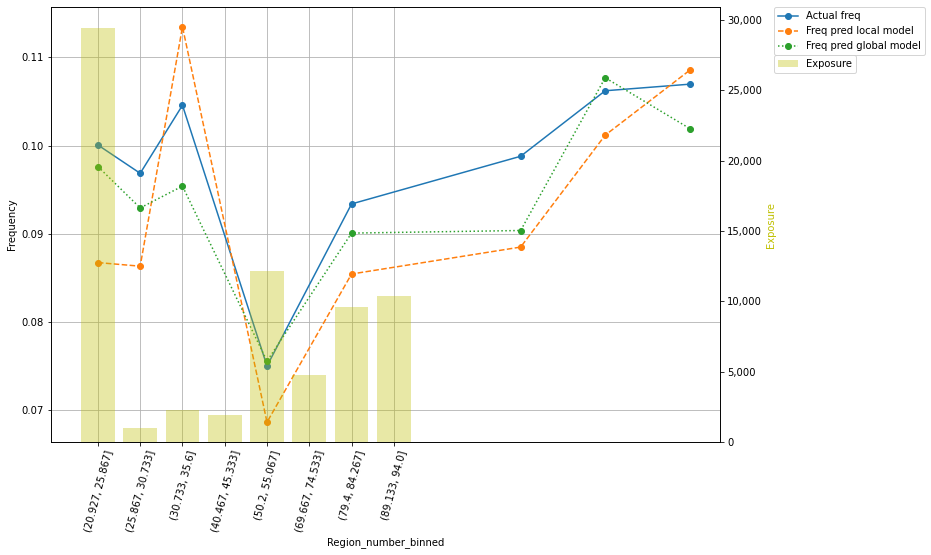

In [28]:
one_way_graph_comparison('Region_number')

C:\Users\dylan\AppData\Local\Temp\ipykernel_41948\3342799862.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sum=df_test.groupby([factor+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_agent_pred'].sum().reset_index()


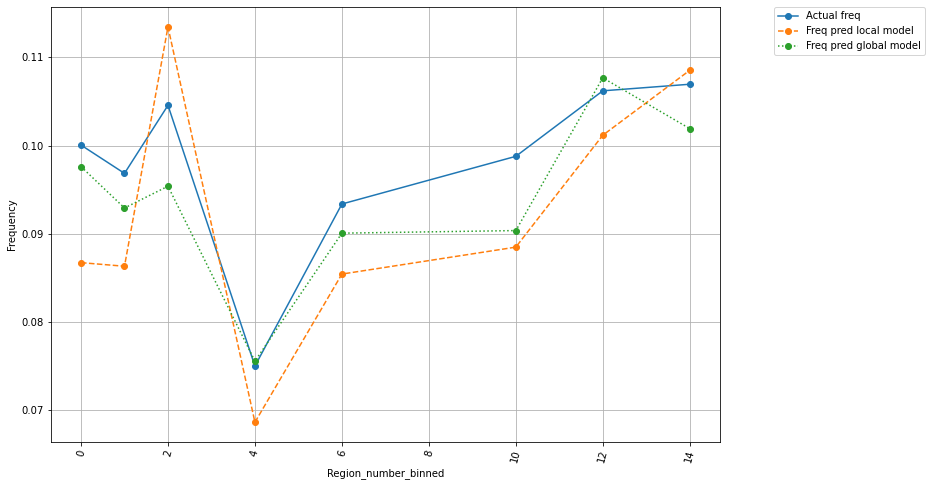

In [26]:
df_sum = create_df_sum(df_test, 'Region_number', X_test, loaded_net_regr, loaded_net_regr_0)

fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(df_sum['Actual freq'],  
        label='Actual freq',
        marker='o',
        )

plt.plot(df_sum['Freq pred local model'],  
        label='Freq pred local model',
        marker='o',
        linestyle='dashed',
        )

plt.plot(df_sum['Freq pred global model'],  
        label='Freq pred global model',
        marker='o',
        linestyle='dotted',
        )

plt.legend(bbox_to_anchor=(1.08, 1), loc='upper left', borderaxespad=0)

plt.xlabel('Region_number'+'_binned')
plt.xticks(rotation = 75)
plt.ylabel('Frequency')
plt.grid()


# Get second axis
#ax2 = ax.twinx()

#plt.bar(df_sum['Region_number'+'_binned'].astype(str), 
        #df_sum['Exposure'], 
        #label='Exposure', 
        #color='y',
        #alpha=0.35
        #)

#plt.ylabel('Exposure', color='y')
#plt.xticks(rotation = 90)

#vals = ax2.get_yticks()
#ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

#plt.legend(bbox_to_anchor=(1.08, 0.89), loc='upper left', borderaxespad=0)

plt.show()

C:\Users\dylan\AppData\Local\Temp\ipykernel_41948\3342799862.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sum=df_test.groupby([factor+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_agent_pred'].sum().reset_index()


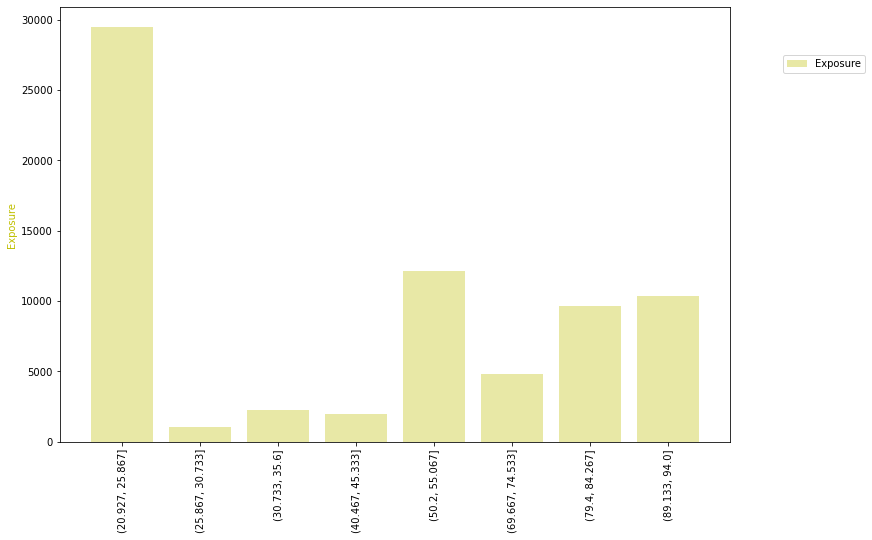

In [30]:
df_sum = create_df_sum(df_test, 'Region_number', X_test, loaded_net_regr, loaded_net_regr_0)

fig, ax = plt.subplots(figsize=(12, 8))


plt.bar(df_sum['Region_number'+'_binned'].astype(str), 
        df_sum['Exposure'], 
        label='Exposure', 
        color='y',
        alpha=0.35
        )

plt.ylabel('Exposure', color='y')
plt.xticks(rotation = 90)


plt.legend(bbox_to_anchor=(1.08, 0.89), loc='upper left', borderaxespad=0)

plt.show()

In [31]:
df_sum

,Region_number_binned,Region_number_binned_midpoint,Exposure,ClaimNb,ClaimNb_pred,ClaimNb_agent_pred,Actual freq,Freq pred global model,Freq pred local model
0,"(20.927, 25.867]",23.0,29443.414449,2946.0,2874.042429,2553.388695,0.100056,0.097612,0.086722
1,"(25.867, 30.733]",28.0,1001.576874,97.0,93.066426,86.449258,0.096847,0.092920,0.086313
2,"(30.733, 35.6]",33.0,2266.571267,237.0,216.211252,257.167631,0.104563,0.095391,0.113461
4,"(40.467, 45.333]",43.0,1933.384279,145.0,146.065092,132.676221,0.074998,0.075549,0.068624
6,"(50.2, 55.067]",53.0,12144.883568,1134.0,1093.833794,1037.495380,0.093373,0.090065,0.085427
10,"(69.667, 74.533]",72.0,4788.453020,473.0,432.682612,423.694663,0.098779,0.090360,0.088483
12,"(79.4, 84.267]",82.0,9622.549978,1022.0,1036.204365,973.529984,0.106209,0.107685,0.101172
14,"(89.133, 94.0]",92.0,10368.863219,1109.0,1056.837757,1125.393783,0.106955,0.101924,0.108536


In [24]:
df_sum.loc[df_sum['Exposure']!=0]

,Region_number_binned,Region_number_binned_midpoint,Exposure,ClaimNb,ClaimNb_pred,ClaimNb_agent_pred,Actual freq,Freq pred global model,Freq pred local model
0,"(20.927, 25.867]",23.0,29443.414449,2946.0,2874.042429,2553.388695,0.100056,0.097612,0.086722
1,"(25.867, 30.733]",28.0,1001.576874,97.0,93.066426,86.449258,0.096847,0.092920,0.086313
2,"(30.733, 35.6]",33.0,2266.571267,237.0,216.211252,257.167631,0.104563,0.095391,0.113461
4,"(40.467, 45.333]",43.0,1933.384279,145.0,146.065092,132.676221,0.074998,0.075549,0.068624
6,"(50.2, 55.067]",53.0,12144.883568,1134.0,1093.833794,1037.495380,0.093373,0.090065,0.085427
10,"(69.667, 74.533]",72.0,4788.453020,473.0,432.682612,423.694663,0.098779,0.090360,0.088483
12,"(79.4, 84.267]",82.0,9622.549978,1022.0,1036.204365,973.529984,0.106209,0.107685,0.101172
14,"(89.133, 94.0]",92.0,10368.863219,1109.0,1056.837757,1125.393783,0.106955,0.101924,0.108536


In [ ]:
def predictions_check(global_model, agent_model, factor):
      
    # Load test data
    
    (X_train, X_val, X_test, y_train, y_val, y_test, X_column_names, scaler) = utils.upload_dataset()
    
    MY_DATA_PATH = '../data'
    
    X_test_sc = pd.read_csv(MY_DATA_PATH + '/X_test.csv')
    y_te = pd.read_csv(MY_DATA_PATH + '/y_test.csv')
    X_column_names = X_test_sc.columns.tolist()

    test_complete_data=np.column_stack((X_test_sc, y_te))

    X_column_names.append('ClaimNb')

    #Convert dataset of test data, actuals, and prediction back into dataframe

    df_test=pd.DataFrame(data=test_complete_data,    # values
                    columns=X_column_names)  # 1st row as the column names
    

    df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']]=scaler.inverse_transform(df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']] )
    
    #Bin certain factors
    factor_list = ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehGas', 'Density']
    
    BINSIZE = 15

    for i in factor_list:
        df_test[i+'_binned'] = pd.cut(df_test[i], bins=BINSIZE, duplicates='drop')


    y_pred = global_model.predict(X_test.astype(np.float64))
    df_test['ClaimNb_pred']=pd.Series(y_pred.flatten())
    y_agent_pred = agent_model.predict(X_test.astype(np.float64))
    df_test['ClaimNb_agent_pred']=pd.Series(y_agent_pred.flatten())

    df_sum=df_test.groupby([factor+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_agent_pred'].sum().reset_index()

    frequency_conversion(factor, df_sum, {'ClaimNb':'Actual freq', 'ClaimNb_pred':'Freq pred global model', 'ClaimNb_agent_pred':'Freq pred local model',})

    return df_sum


In [14]:
def predictions_check(global_model, agent_model, factor):
      
      (X_train, X_val, X_test, y_train, y_val, y_test, X_column_names, scaler) = utils.upload_dataset()
      
      MY_DATA_PATH = '../data'
        
      X_test_sc = pd.read_csv(MY_DATA_PATH + '/X_test.csv')
      y_te = pd.read_csv(MY_DATA_PATH + '/y_test.csv')
      X_column_names = X_test_sc.columns.tolist()

      test_complete_data=np.column_stack((X_test_sc, y_te))

      X_column_names.append('ClaimNb')

      #Convert dataset of test data, actuals, and prediction back into dataframe

      df_test=pd.DataFrame(data=test_complete_data,    # values
                     columns=X_column_names)  # 1st row as the column names
      

      df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']]=scaler.inverse_transform(df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']] )
      
      #Bin certain factors
      factor_list = ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehGas', 'Density']
      BINSIZE = 15

      for i in factor_list:
          df_test[i+'_binned'] = pd.cut(df_test[i], bins=BINSIZE, duplicates='drop')


      y_pred = global_model.predict(X_test.astype(np.float64))
      df_test['ClaimNb_pred']=pd.Series(y_pred.flatten())
      y_agent_pred = agent_model.predict(X_test.astype(np.float64))
      df_test['ClaimNb_agent_pred']=pd.Series(y_agent_pred.flatten())

      # One way analysis
      #FACTOR = 'VehAge'

      df_sum=df_test.groupby([factor+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_agent_pred'].sum().reset_index()

      frequency_conversion(factor, df_sum, {'ClaimNb':'Actual freq', 'ClaimNb_pred':'Freq pred global model', 'ClaimNb_agent_pred':'Freq pred local model',})

      #one_way_graph(FACTOR, df_sum, run_name, ag,  'Actual freq', 'Freq pred global model', 'Freq pred local model','Freq pred FL model')

      return df_sum


In [15]:
df_sum = predictions_check(loaded_net_regr, loaded_net_regr_0, 'VehAge')

C:\Users\dylan\AppData\Local\Temp\ipykernel_42184\768676531.py:39: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sum=df_test.groupby([factor+'_binned'])['Exposure','ClaimNb', 'ClaimNb_pred', 'ClaimNb_agent_pred'].sum().reset_index()


In [16]:
df_sum

,VehAge_binned,VehAge_binned_midpoint,Exposure,ClaimNb,ClaimNb_pred,ClaimNb_agent_pred,Actual freq,Freq pred global model,Freq pred local model
0,"(-0.02, 1.333]",1.0,9822.497753,1581.0,1543.464068,1506.934776,0.160957,0.157136,0.153417
1,"(1.333, 2.667]",2.0,5972.147646,570.0,530.228931,568.657184,0.095443,0.088784,0.095218
2,"(2.667, 4.0]",3.0,10040.595802,906.0,939.147488,895.827735,0.090234,0.093535,0.089221
3,"(4.0, 5.333]",5.0,4554.388179,447.0,437.451441,388.698802,0.098147,0.096051,0.085346
4,"(5.333, 6.667]",6.0,4134.774617,406.0,392.113143,343.598894,0.098192,0.094833,0.083100
5,"(6.667, 8.0]",7.0,7777.018238,784.0,736.111613,640.397997,0.100810,0.094652,0.082345
6,"(8.0, 9.333]",9.0,3720.406266,356.0,341.718833,299.484970,0.095688,0.091850,0.080498
7,"(9.333, 10.667]",10.0,4195.815758,423.0,390.869737,345.823359,0.100815,0.093157,0.082421
8,"(10.667, 12.0]",11.0,3447.614425,304.0,292.110000,267.977515,0.088177,0.084728,0.077728
9,"(12.0, 13.333]",13.0,6688.288191,608.0,546.782424,509.923170,0.090905,0.081752,0.076241


C:\Users\dylan\AppData\Local\Temp\ipykernel_42184\3355080530.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


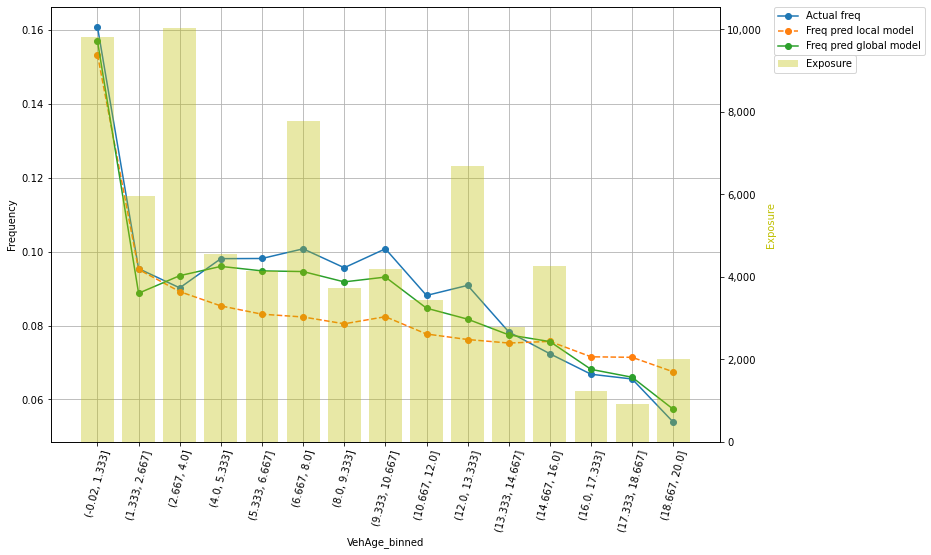

In [18]:
one_way_graph_comparison(df_sum, 'VehAge')

KeyError: 'DrivAge_binned'

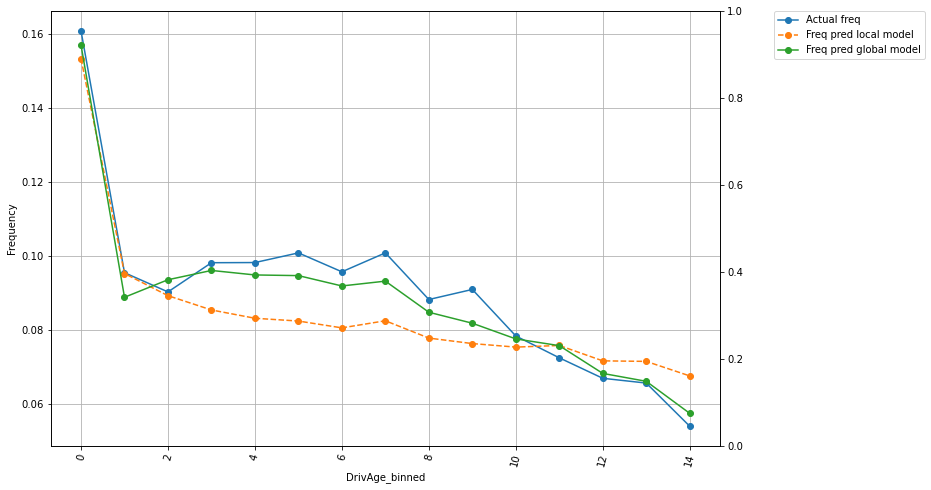

In [19]:
one_way_graph_comparison(df_sum, 'DrivAge')